# Comparing the effects of a $p\pi^0$ mass cut on PWA Results
In the higher $\omega\pi^0$ mass region, baryon excitations become noticeable in the $p\pi^0$ mass spectrum. While we don't fit the $p\pi^0$ mass we *do* fit the $\cos\theta$ distribution, and these excited baryon events (typically $\Delta$'s) will appear at $\cos\theta\sim 1$. This happens as $\cos\theta$ measures the angle of of the $\omega$ in the resonance rest frame, so values close to 1 mean the $\pi^0$ is moving close to the proton, which happens when they are the decay products of an $N^\ast$. 

This notebook will analyze what effects will occur when these excitations, specifically events whose $p\pi^0$ mass is $<1.4~GeV$, are removed. Later on this ideally will flow into a full systematic study of this cut, but for now we can see the effect of this harsh mass cut. The style and structure will be *very* similar to the [compare orientations notebook](./compare_orientations.ipynb).

Some Fit details are given below:
* Bins: 
  * $t$ = [0.1, 0.2, 0.3, 0.5, 0.9]
  * mass = 1.0 - 1.5, 20 MeV bins
* Waveset: S, P, D wave with D/S constrained. All $m$'s and $\epsilon$'s. Isotropic background wave included

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

from pathlib import Path    
import sys, os
parent_dir = str(Path().resolve().parents[1])
sys.path.insert(0, parent_dir)
import analysis.scripts.pwa_tools as pwa_tools

# Load and Process Data

Let's first loop over all our csv files and collect them into 2 big dataframes: one that holds the fit results and the other all the raw bin data. Each dataframe will have an `cut` and `t` label to denote which cut value (`0` or `1.4`) and $-t$ bin each row is from.

Reminder: Each csv is for a particular $-t$ bin, and its rows are the sorted mass bins (least to greatest). So there will be "chunks" of many rows that correspond to the set of mass independent fits in a particular $-t$ bin.

In [3]:
# loop over all csv's and collect them into 2 lists
path = f"{parent_dir}/analysis/small-mass-range-study/ppi0_mass_cut_compare"
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

df_list = []
df_data_list = []

for csv in csv_files:
    # the following assumes string always in form "mass-cut_t-bin1-bin2(_data).csv". () denote its optional
    i = csv.index("_")
    mass_cut = csv[0:i]
    t_range = csv[i+3:i+10]
    if "data" in csv:
        print(f"Adding data df:\t{csv}")                
        df_data = pd.read_csv(f"{path}/{csv}")
        df_data["cut"] = mass_cut
        df_data["t"] = t_range
        df_data_list.append(df_data)
    else:
        print(f"Adding fit df:\t{csv}")
        df = pd.read_csv(f"{path}/{csv}", index_col="index")
        df["cut"] = mass_cut
        df["t"] = t_range
        pwa_tools.wrap_phases(df)
        df_list.append(df)

df = pd.concat(df_list)
df_data = pd.concat(df_data_list)

Adding fit df:	1.4_t-0.5-0.9.csv
Adding data df:	0.0_t-0.2-0.3_data.csv
Adding data df:	1.4_t-0.5-0.9_data.csv
Adding fit df:	1.4_t-0.2-0.3.csv
Adding data df:	0.0_t-0.3-0.5_data.csv
Adding data df:	0.0_t-0.1-0.2_data.csv
Adding fit df:	1.4_t-0.3-0.5.csv
Adding fit df:	0.0_t-0.1-0.2.csv
Adding fit df:	0.0_t-0.2-0.3.csv
Adding data df:	0.0_t-0.5-0.9_data.csv
Adding data df:	1.4_t-0.3-0.5_data.csv
Adding data df:	1.4_t-0.1-0.2_data.csv
Adding fit df:	0.0_t-0.3-0.5.csv
Adding fit df:	1.4_t-0.1-0.2.csv
Adding fit df:	0.0_t-0.5-0.9.csv
Adding data df:	1.4_t-0.2-0.3_data.csv


In [3]:
# use mass bins from one cut and t-bin
MASS_BINS = df_data[(df_data["cut"]=="1.4") & (df_data["t"]=="0.1-0.2")]["mean"]
# double check that this is valid
for temp_df in df_data_list:        
    if (abs(temp_df["mean"] - MASS_BINS) > 0.005).any():
        print(f"Mass binning differs significantly between dataframes")
bin_width = (df_data[(df_data["cut"]=="1.4") & (df_data["t"]=="0.1-0.2")]["high_edge"] - df_data[(df_data["cut"]=="1.4") & (df_data["t"]=="0.1-0.2")]["low_edge"])[0]
coherent_sums = pwa_tools.get_coherent_sums(df)
phase_differences = pwa_tools.get_phase_differences(df)

## Quality Checks


The simplest way to check that all bins were collected is to make sure the number of mass bins in each t bin is consistent

In [4]:
for fit_df in df_list:
    if len(fit_df.index) != len(MASS_BINS):
        print(f"Dataframe t={fit_df["t"][0]} cut={fit_df["cut"][0]} has missing entries!")

To make sure each dataframe is labelled correctly for each t-bin, we can pick the mass bin with the most events and plot as a function of t. If its shape is linear when plotted for a logarithmic scaled y-axis, then it matches the expected exponential t decay

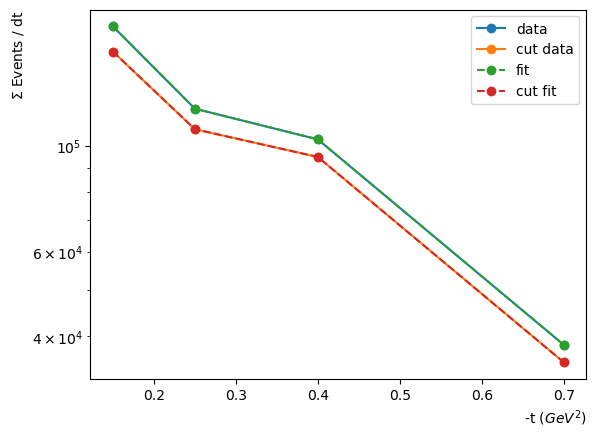

In [5]:
x = [0.15, 0.25, 0.4, 0.7] # center of t bins
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]

y_data = []
y_data_cut = []
y_fit = []
y_fit_cut = []
for t_cut in t_cuts:
    y_data.append(df_data[(df_data["cut"]=="0.0") & (df_data["t"]==t_cut)]["bin_contents"][10])
    y_data_cut.append(df_data[(df_data["cut"]=="1.4") & (df_data["t"]==t_cut)]["bin_contents"][10])
    y_fit.append(df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["detected_events"][10])
    y_fit_cut.append(df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["detected_events"][10])
plt.plot(x, y_data, label = "data", linestyle="-", marker="o")
plt.plot(x, y_data_cut, label = "cut data", linestyle="-", marker="o")
plt.plot(x, y_fit, label = "fit", linestyle="--", marker="o")
plt.plot(x, y_fit_cut, label = "cut fit", linestyle="--", marker="o")

plt.ylabel(r"$\Sigma$ Events / dt", loc="top")
plt.xlabel(r"-t $(GeV^2)$", loc="right")
plt.legend()
plt.yscale("log")

# Isotropic Background Check
When comparing orientations (which contained no $p\pi^0$ cut) there was significant contribution from the isotropic background wave in the high mass bins and low t bins. We can now see whether applying the mass cut removes the background contribution's strength

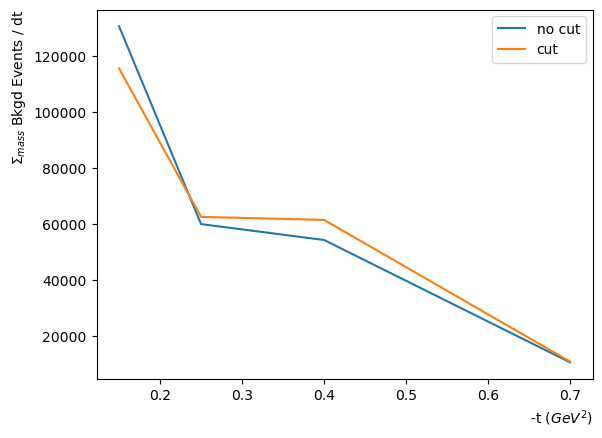

In [6]:
x = [0.15, 0.25, 0.4, 0.7] # center of t bins
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
y = []
y_cut = []
for t_cut in t_cuts:
    y.append(df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["Bkgd"].sum())
    y_cut.append(df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["Bkgd"].sum())

plt.plot(x, y, label="no cut")
plt.plot(x, y_cut, label="cut")
plt.xlabel(r"-t $(GeV^2)$", loc="right")
plt.ylabel(r"$\Sigma_{mass}$ Bkgd Events / dt", loc="top")
plt.legend()

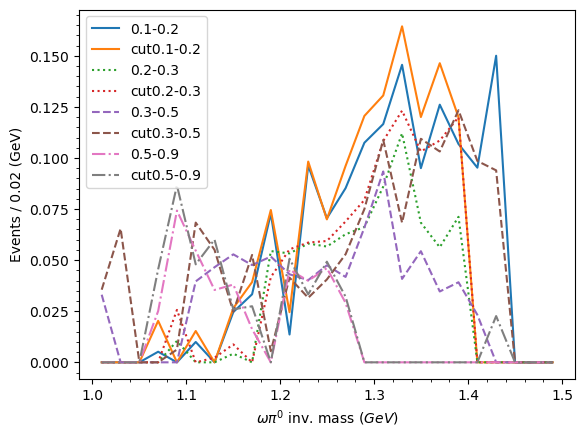

In [7]:
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
t_lines = ["solid", "dotted", "dashed", "dashdot"]
for i, t_cut in enumerate(t_cuts):
    bkgd = df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["Bkgd"]
    data = df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["detected_events"]

    bkgd_cut = df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["Bkgd"]
    data_cut = df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["detected_events"]
    
    plt.plot(MASS_BINS, bkgd/data, linestyle=t_lines[i], label=f"{t_cut}")
    plt.plot(MASS_BINS, bkgd_cut/data_cut, linestyle=t_lines[i], label=f"cut{t_cut}")

plt.xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$")
plt.ylabel(r"Events / 0.02 (GeV)")
plt.minorticks_on()
plt.legend()
plt.show()

Oof

# Analysis

## $b_1$ and $\rho^\ast$ interaction

Past studies indicate the $1^+ S_0^+$ and $1^- P_1^+$ waves capture the $b_1$ and $\rho^\ast$ resonances respectively. Plotting their intensities and phase as a function of mass will show whether these are present and stable in the data

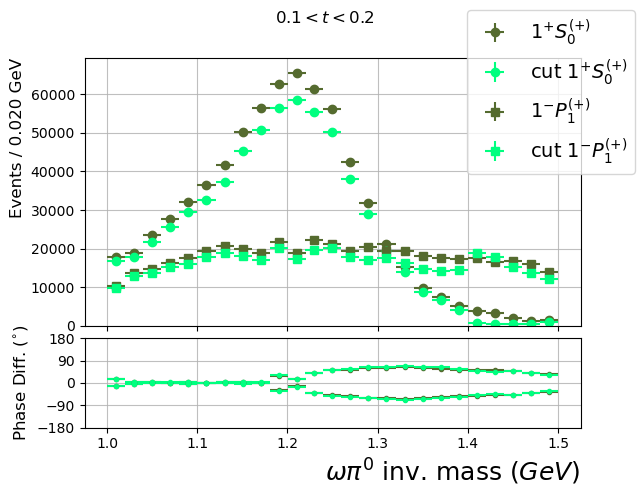

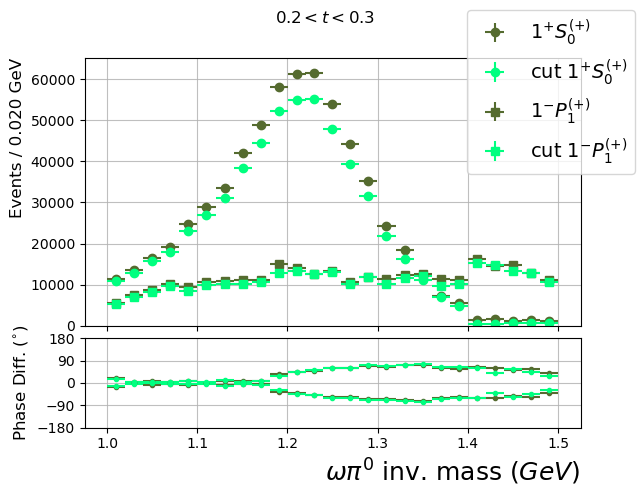

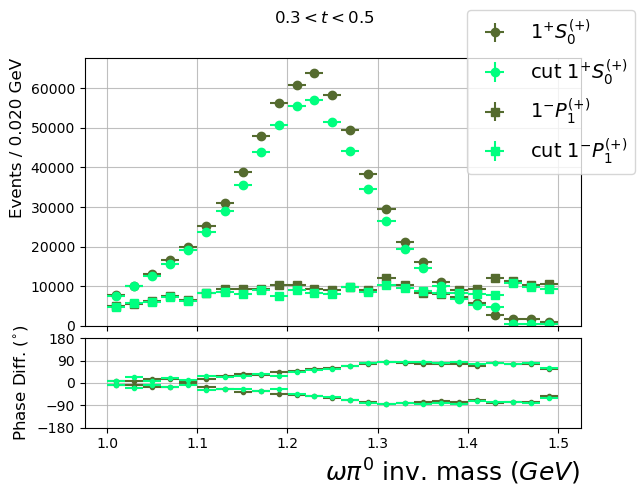

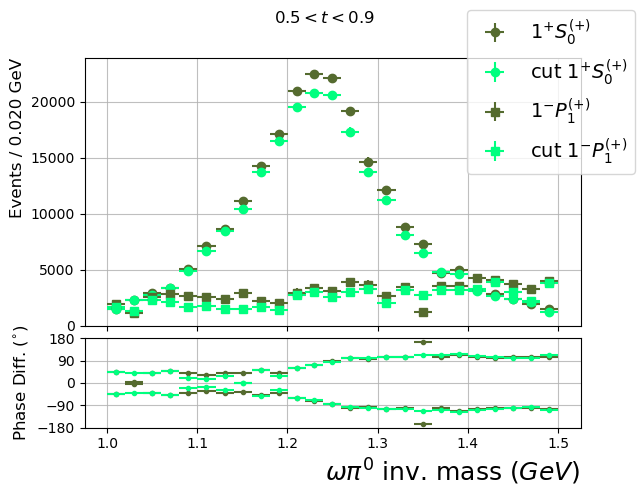

In [34]:
# basically copying the pwa_tools.Plotter.mass_phase method but including both orientations on one plot
def mass_phase(t_range):
    fig, axs = plt.subplots(
                2,
                1,
                sharex=True,
                gridspec_kw={"wspace": 0.0, "hspace": 0.07},
                height_ratios=[3, 1],
            )

    axs[0].errorbar(
        MASS_BINS, 
        df[(df["cut"]=="0.0") & (df["t"]==t_range)]["p1p0S"],
        df[(df["cut"]=="0.0") & (df["t"]==t_range)]["p1p0S_err"],     
        bin_width/2,
        "o", color="darkolivegreen", label=f"{pwa_tools.convert_amp_name('p1p0S')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["p1p0S"],
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["p1p0S_err"],     
        bin_width/2,
        "o", color="springgreen", label=f"cut {pwa_tools.convert_amp_name('p1p0S')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["cut"]=="0.0") & (df["t"]==t_range)]["p1mpP"],
        df[(df["cut"]=="0.0") & (df["t"]==t_range)]["p1mpP_err"],     
        bin_width/2,
        "s", color="darkolivegreen", label=f"{pwa_tools.convert_amp_name('p1mpP')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["p1mpP"],
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["p1mpP_err"],     
        bin_width/2,
        "s", color="springgreen", label=f"cut {pwa_tools.convert_amp_name('p1mpP')}",
    )


    phase_dif = phase_differences[("p1p0S", "p1mpP")]
    axs[1].errorbar(
        MASS_BINS,
        df[(df["cut"]=="0.0") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["cut"]=="0.0") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="darkolivegreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        -df[(df["cut"]=="0.0") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["cut"]=="0.0") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="darkolivegreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        df[(df["cut"]=="1.4") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["cut"]=="1.4") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="springgreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        -df[(df["cut"]=="1.4") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["cut"]=="1.4") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="springgreen"
    )

    # cosmetics
    for ax in axs.reshape(-1):
        ax.grid(True, alpha=0.8)

    axs[0].set_ylim(bottom=0.0)
    axs[0].set_ylabel(f"Events / {bin_width:.3f} GeV", loc="top", fontsize=12)

    axs[1].set_yticks(np.linspace(-180, 180, 5))  # force to be in pi/2 intervals
    axs[1].set_ylim([-180, 180])
    axs[1].set_ylabel(r"Phase Diff. ($^{\circ}$)", loc="center", fontsize=12)
    axs[1].set_xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$", loc="right", fontsize=18)

    fig.legend(fontsize=14, loc="upper right")
    fig.suptitle(rf"${t_range[0:3]} < t < {t_range[4:7]}$")
    plt.show()

mass_phase("0.1-0.2")
mass_phase("0.2-0.3")
mass_phase("0.3-0.5")
mass_phase("0.5-0.9")

## Intensities
Now lets see how all the other intensities are fairing

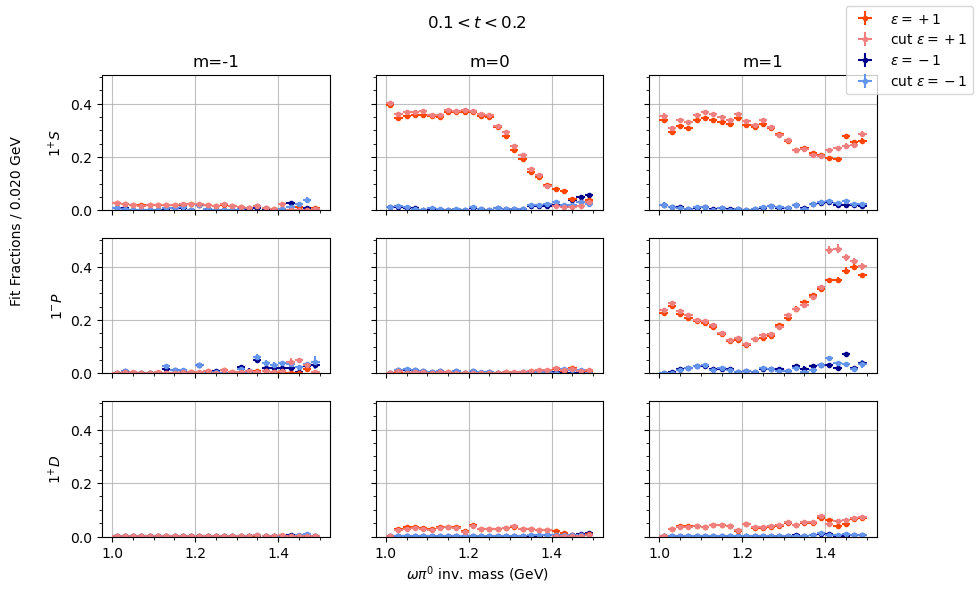

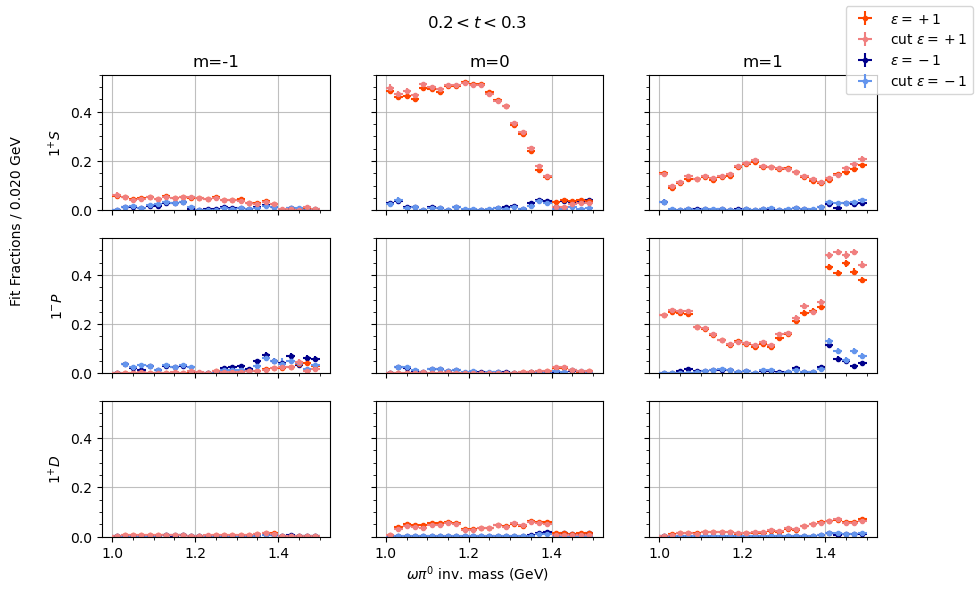

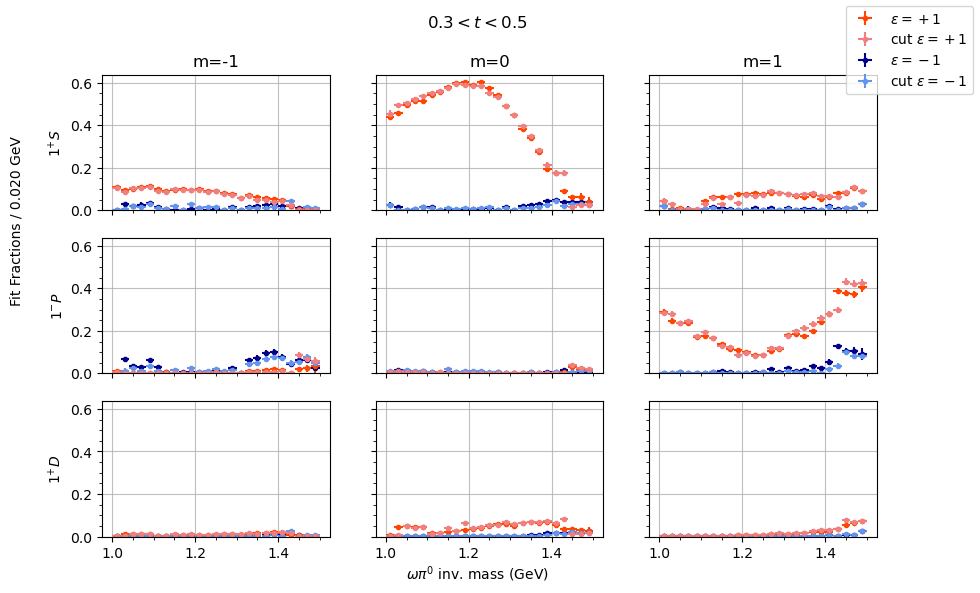

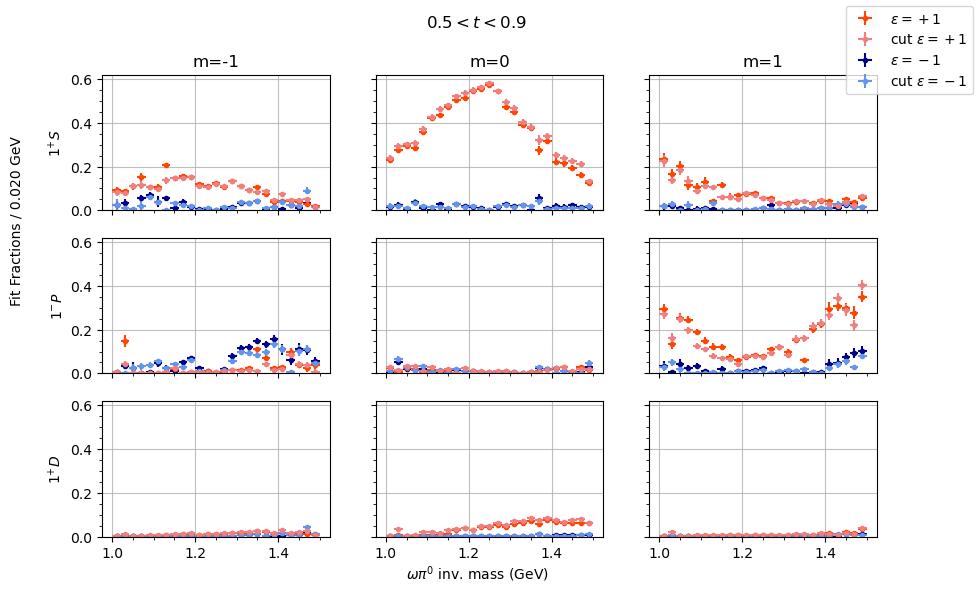

In [65]:
# code is basically a copy of the pwa_tools.Plotter.intensities() method
char_to_int = {"m": -1, "0": 0, "p": +1, "S": 0, "P": 1, "D": 2, "F": 3}
int_to_char = {-1: "m", 0: "0", +1: "p"}
pm_dict = {"m": "-", "p": "+"}

# need to sort on the integer versions of the m-projections
m_ints = sorted({char_to_int[JPm[-1]] for JPm in coherent_sums["JPm"]})

t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]

for t_cut in t_cuts:
    fig, axs = plt.subplots(
        len(m_ints),
        len(coherent_sums["JPL"]),
        sharex=True,
        sharey=True,
        figsize=(10,6)
    )
    total = df_data[(df_data["cut"]=="0.0") & (df_data["t"]==t_cut)]["bin_contents"]
    total_err = df_data[(df_data["cut"]=="0.0") & (df_data["t"]==t_cut)]["bin_error"]
    total_cut = df_data[(df_data["cut"]=="1.4") & (df_data["t"]==t_cut)]["bin_contents"]
    total_cut_err = df_data[(df_data["cut"]=="1.4") & (df_data["t"]==t_cut)]["bin_error"]

    # set these if you don't want to plot fit fractions
    # total = 1
    # total_err = 0
    # total_cut = 1
    # total_cut_err = 0

    df_no_cut = df[(df["cut"]=="0.0") & (df["t"]==t_cut)]
    df_cut = df[(df["cut"]=="1.4") & (df["t"]==t_cut)]

    # iterate through JPL (sorted like S, P, D, F wave) and sorted m-projections
    for row, jpl in enumerate(
        sorted(coherent_sums["JPL"], key=lambda JPL: char_to_int[JPL[-1]])
    ):
        for col, m in enumerate(m_ints):
            JPmL = f"{jpl[0:2]}{int_to_char[m]}{jpl[-1]}"

            if row == 0:
                axs[row, col].set_title(f"m={char_to_int[JPmL[-2]]}")
            if col == 0:
                axs[row, col].set_ylabel(rf"${JPmL[0]}^{{{pm_dict[JPmL[1]]}}}{JPmL[-1]}$")            

            neg_plot_0_90 = axs[row, col].errorbar(
                MASS_BINS,
                df_no_cut["m" + JPmL] / total,
                (df_no_cut["m" + JPmL] / total) * np.sqrt(np.square(df_no_cut["m"+JPmL+"_err"]/df_no_cut["m"+JPmL]) + np.square(total_err / total)),
                bin_width / 2,
                ".",
                color="darkblue",                
                label=r"$\epsilon=-1$",
            )
            pos_plot_0_90 = axs[row, col].errorbar(
                MASS_BINS,
                df_no_cut["p" + JPmL] / total,
                (df_no_cut["p" + JPmL] / total) * np.sqrt(np.square(df_no_cut["p"+JPmL+"_err"]/df_no_cut["p"+JPmL]) + np.square(total_err / total)),
                bin_width / 2,
                ".",
                color="orangered",                
                label=r"$\epsilon=+1$",
            )

            neg_plot_45_135 = axs[row, col].errorbar(
                MASS_BINS,
                df_cut["m" + JPmL] / total_cut,
                (df_cut["m" + JPmL] / total_cut) * np.sqrt(np.square(df_cut["m"+JPmL+"_err"]/df_cut["m"+JPmL]) + np.square(total_cut_err / total_cut)),
                bin_width / 2,
                ".",
                color="cornflowerblue",                
                label=r"cut $\epsilon=-1$",
            )
            pos_plot_45_135 = axs[row, col].errorbar(
                MASS_BINS,
                df_cut["p" + JPmL] / total_cut,
                (df_cut["p" + JPmL] / total_cut) * np.sqrt(np.square(df_cut["p"+JPmL+"_err"]/df_cut["p"+JPmL]) + np.square(total_cut_err / total_cut)),
                bin_width / 2,
                ".",
                color="lightcoral",                
                label=r"cut $\epsilon=+1$",
            )

    # plot grids
    for ax in axs.reshape(-1):
        ax.grid(True, alpha=0.8)
        ax.set_ylim(bottom=0)
    plt.minorticks_on()        

    # figure cosmetics
    fig.text(0.5, 0.04, r"$\omega\pi^0$ inv. mass (GeV)", ha="center")
    fig.text(
        0.04,
        0.5,
        f"Fit Fractions / {bin_width:.3f} GeV",
        ha="center",        
        rotation="vertical",
    )
    fig.suptitle(rf"${t_cut[0:3]} < t < {t_cut[4:7]}$")
    fig.legend(handles=[pos_plot_0_90, pos_plot_45_135, neg_plot_0_90, neg_plot_45_135], loc="upper right")
    plt.show()

## Cross Section

Before we go about trying to plot the cross section, lets see what just the total $1^+ \Sigma \ell_{\Sigma m}^+$ coherent sum looks like to check whether its shape is even breit wigner like across t bins

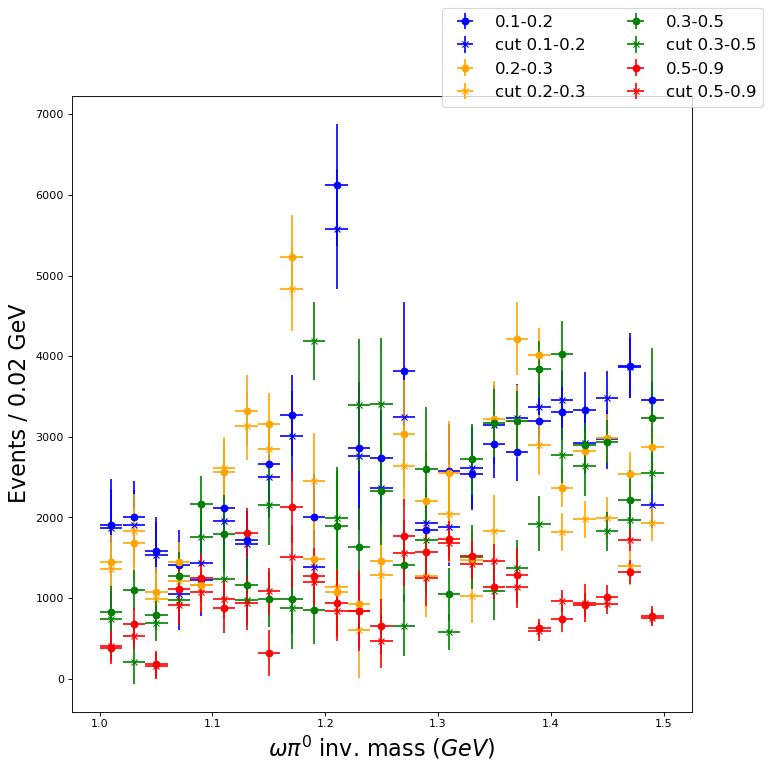

In [8]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
colors=["blue", "orange", "green", "red"]
for i, t_cut in enumerate(t_cuts):
    ax.errorbar(
        MASS_BINS, 
        df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["m1p"], 
        df[(df["cut"]=="0.0") & (df["t"]==t_cut)]["m1p_err"],
        bin_width/2,
        linestyle="",
        marker="o",
        color = colors[i],
        label=f"{t_cut}"
    )
    ax.errorbar(
        MASS_BINS, 
        df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["m1p"], 
        df[(df["cut"]=="1.4") & (df["t"]==t_cut)]["m1p_err"],
        bin_width/2,
        linestyle="",
        marker = "x",
        color = colors[i],
        label=f"cut {t_cut}"
    )

ax.set_ylabel("Events / 0.02 GeV", fontsize=20)
ax.set_xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$", fontsize=20)
fig.legend(ncol=2, loc="upper right", fontsize=15)
plt.show()

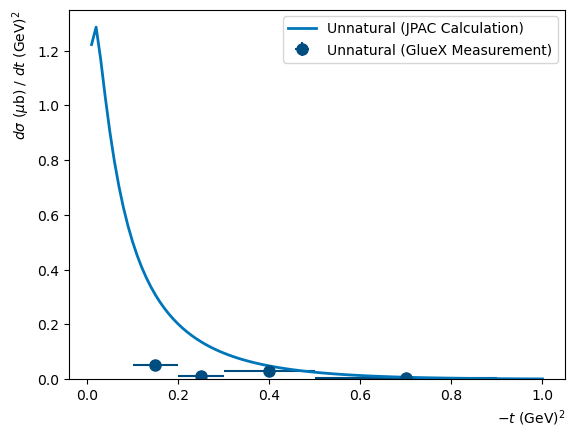

In [9]:
import scipy.integrate as integrate
def breit_wigner(x, m, width):
    gamma = math.sqrt(m**2 * (m**2 + width**2))

    k = (2 * math.sqrt(2) * m * width * gamma) / (math.pi * math.sqrt(m**2 + gamma))

    result = k / ((x**2 - m**2) ** 2 + m**2 * width**2)

    return result

cs_path = f"{parent_dir}/analysis/data/cross_section"

df_data = pd.read_csv(f"{cs_path}/1.4_m-1.22-1.24.csv", index_col="index")
df_theory = pd.read_csv(f"{cs_path}/piExch-B1neutral.txt", sep=r"\s+", names=["t", "dsigma"])
# get fraction of b1 breit wigner covered by the mass bin
total_int = integrate.quad(breit_wigner, 0, math.inf, args=(1.235, 0.142))
bin_int = integrate.quad(breit_wigner, 1.22, 1.24, args=(1.235, 0.142))
frac = 1 / (bin_int[0] / total_int[0])

# plot params
LUM = 117858000  # ub^{-1} (old 125000000)
BF = 0.892  # omega->3pi branching fraction (from pdg)

t_bins = [0.15, 0.25, 0.4, 0.7]
bin_error = np.array([0.1, 0.1, 0.2, 0.4])
t_width = np.array([0.1, 0.1, 0.2, 0.4])

# plot coherent sum of negative refl m-projections
plt.errorbar(
    t_bins,
    (df_data["m1p"]) / (BF * LUM * t_width) * frac,
    (df_data["m1p_err"]) / (BF * LUM * t_width) * frac,
    bin_error/2,
    color="#004D80",
    marker=".",
    markersize=16,
    linestyle="",
    label="Unnatural (GlueX Measurement)",
)
plt.plot(
    df_theory["t"],
    df_theory["dsigma"],
    color="#0076BA",
    marker="",
    linestyle="-",
    linewidth=2.0,
    label="Unnatural (JPAC Calculation)",
)

# Cosmetics
plt.xlabel(r"$-t$ (GeV)$^{{2}}$", loc="right")
plt.ylabel(r"$d\sigma$ ($\mu$b) / $dt$ (GeV)$^2$", loc="top")
plt.gca().set_ylim(bottom=0)

plt.legend()
plt.show()

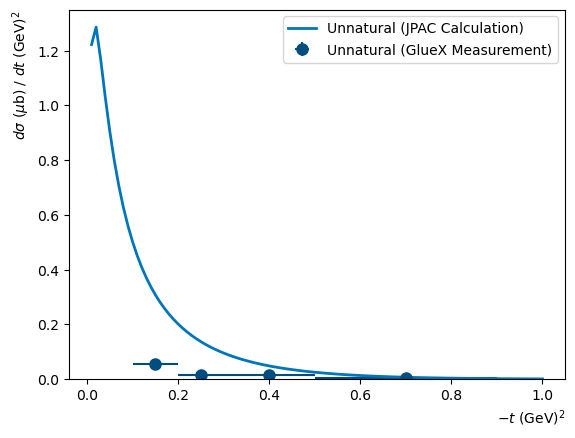

In [10]:
# maybe try on the no cut datafiles
df_data = pd.read_csv(f"{cs_path}/0.0_m-1.22-1.24.csv", index_col="index")

# plot coherent sum of negative refl m-projections
plt.errorbar(
    t_bins,
    (df_data["m1p"]) / (BF * LUM * t_width) * frac,
    (df_data["m1p_err"]) / (BF * LUM * t_width) * frac,
    bin_error/2,
    color="#004D80",
    marker=".",
    markersize=16,
    linestyle="",
    label="Unnatural (GlueX Measurement)",
)
plt.plot(
    df_theory["t"],
    df_theory["dsigma"],
    color="#0076BA",
    marker="",
    linestyle="-",
    linewidth=2.0,
    label="Unnatural (JPAC Calculation)",
)

# Cosmetics
plt.xlabel(r"$-t$ (GeV)$^{{2}}$", loc="right")
plt.ylabel(r"$d\sigma$ ($\mu$b) / $dt$ (GeV)$^2$", loc="top")
plt.gca().set_ylim(bottom=0)

plt.legend()
plt.show()

## D/S Ratio
The instability and discrepancy in the cross section could be because the D/S ratio is now fixed, whereas before we were letting it float freely. Lets first plot what the D/S ratio is here

0.1-0.2
0.2-0.3
0.3-0.5
0.5-0.9


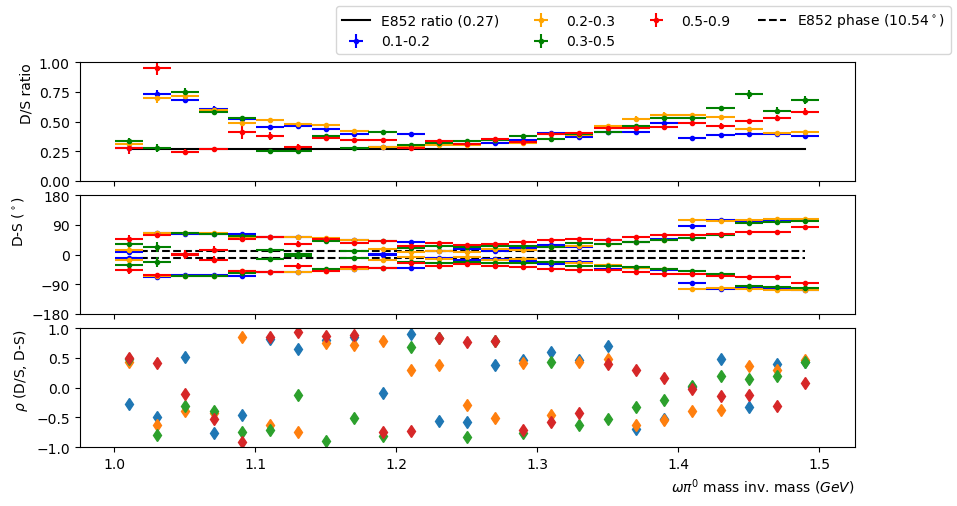

In [66]:
fig, axs = plt.subplots(
    3, 1, sharex=True, gridspec_kw={"wspace": 0.0, "hspace": 0.12}, figsize = (10,5)
)
ax_ratio, ax_phase, ax_corr = axs
# plot nominal values first
ax_ratio.plot(  # plot the nominal ratio
    MASS_BINS,
    np.full_like(MASS_BINS, 0.27),
    "k-",
    label="E852 ratio (0.27)",
)
ax_phase.plot(  # plot the nominal phase (in degrees)
    MASS_BINS,
    np.full_like(MASS_BINS, 10.54),
    "k--",
    label=r"E852 phase $(10.54^\circ)$",
)
ax_phase.plot(MASS_BINS, np.full_like(MASS_BINS, -10.54), "k--")

colors= ["blue", "orange", "green", "red"]
for i, t_range in enumerate(t_cuts):    
    print(t_range)
    ax_ratio.errorbar(
        MASS_BINS,
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dsratio"],
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dsratio_err"],
        bin_width / 2,
        marker=".",
        linestyle="",
        color=colors[i],
        label=t_range,        
    )    
    ax_phase.errorbar(
        MASS_BINS,
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dphase"].apply(np.rad2deg),
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dphase_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        marker=".",
        linestyle="",
        color=colors[i],        
    )
    ax_phase.errorbar(
        MASS_BINS,
        -df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dphase"].apply(np.rad2deg),
        df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dphase_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        marker=".",
        linestyle="",
        color=colors[i],        
    )
    # CORRELATION PLOT
    ax_corr.plot(
        MASS_BINS,
        (
            df[(df["cut"]=="1.4") & (df["t"]==t_range)]["cov_dsratio_dphase"]
            / (df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dsratio_err"] 
            * df[(df["cut"]=="1.4") & (df["t"]==t_range)]["dphase_err"])
        ).fillna(0),
        marker="d",
        linestyle="",        
    )


# COSMETICS
ax_ratio.set_ylabel("D/S ratio", loc="top")
ax_ratio.set_ylim(0, 1)

ax_phase.set_ylabel(r"D-S (${{}}^\circ$)", loc="top")
ax_phase.set_yticks(np.linspace(-180.0, 180.0, 5))
ax_phase.set_ylim(-180.0, 180.0)

ax_corr.set_xlabel(r"$\omega\pi^0$ mass inv. mass $(GeV)$", loc="right")
ax_corr.set_ylabel(r"$\rho$ (D/S, D-S)", loc="top")
ax_corr.set_ylim(-1, 1)

fig.legend(ncols=4)
plt.show()

Now lets plot the D/S ratio and cross section for the free model results in a single mass bin

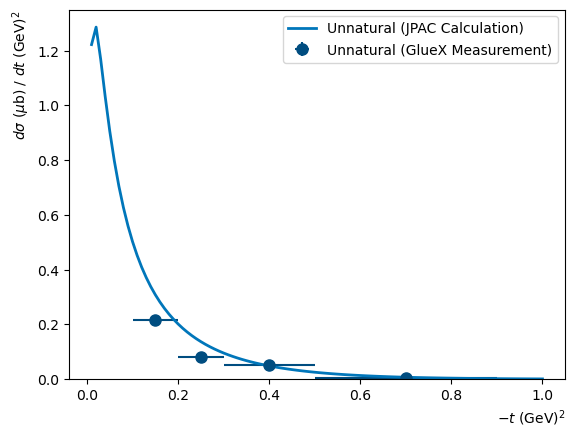

In [5]:
import scipy.integrate as integrate
def breit_wigner(x, m, width):
    gamma = math.sqrt(m**2 * (m**2 + width**2))

    k = (2 * math.sqrt(2) * m * width * gamma) / (math.pi * math.sqrt(m**2 + gamma))

    result = k / ((x**2 - m**2) ** 2 + m**2 * width**2)

    return result

cs_path = f"{parent_dir}/analysis/data/cross_section"

df_cs = pd.read_csv(f"{cs_path}/free_1.4_m-1.22-1.24.csv", index_col="index")
df_theory = pd.read_csv(f"{cs_path}/piExch-B1neutral.txt", sep=r"\s+", names=["t", "dsigma"])
# get fraction of b1 breit wigner covered by the mass bin
total_int = integrate.quad(breit_wigner, 0, math.inf, args=(1.235, 0.142))
bin_int = integrate.quad(breit_wigner, 1.22, 1.24, args=(1.235, 0.142))
frac = 1 / (bin_int[0] / total_int[0])

# plot params
LUM = 117858000  # ub^{-1} (old 125000000)
BF = 0.892  # omega->3pi branching fraction (from pdg)

t_bins = [0.15, 0.25, 0.4, 0.7]
bin_error = np.array([0.1, 0.1, 0.2, 0.4])
t_width = np.array([0.1, 0.1, 0.2, 0.4])

# plot coherent sum of negative refl m-projections
plt.errorbar(
    t_bins,
    (df_cs["m1p"]) / (BF * LUM * t_width) * frac,
    (df_cs["m1p_err"]) / (BF * LUM * t_width) * frac,
    bin_error/2,
    color="#004D80",
    marker=".",
    markersize=16,
    linestyle="",
    label="Unnatural (GlueX Measurement)",
)
plt.plot(
    df_theory["t"],
    df_theory["dsigma"],
    color="#0076BA",
    marker="",
    linestyle="-",
    linewidth=2.0,
    label="Unnatural (JPAC Calculation)",
)

# Cosmetics
plt.xlabel(r"$-t$ (GeV)$^{{2}}$", loc="right")
plt.ylabel(r"$d\sigma$ ($\mu$b) / $dt$ (GeV)$^2$", loc="top")
plt.gca().set_ylim(bottom=0)

plt.legend()
plt.show()

Okay thats looking a lot more reasonable! Since this may be the more viable result, lets compare the D/S constraint in [a new notebook](./compare_ds_constraint.ipynb)